### Preprocessing on Official and Wikipedia

In [1]:

import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "dataset/official"
WIKI_DIR = "dataset/Wikipedia"
OUT_PATH = "Residuals_Paths/official_wiki_residuals.pkl"


# Preprocessing helpers

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs

    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)


# Dataset Processing

def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f" Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals


# Main Execution

residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

# Ensure output directory exists
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)

# Save residuals
with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f" ✅ Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")


 Preprocessing Official images...


100%|██████████| 11/11 [00:45<00:00,  4.10s/it]


 Preprocessing Wikipedia images...


100%|██████████| 11/11 [00:50<00:00,  4.56s/it]


 ✅ Saved Official+Wiki residuals (150 & 300 separately) to Residuals_Paths/official_wiki_residuals.pkl


### Preprocessing on Flatfield                                                      

In [2]:
import os, pickle, cv2, numpy as np
from tqdm import tqdm

# 1) Auto-locate Flatfield folder

def find_flatfield(base="dataset"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":   # case-insensitive search
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("dataset")
if not flatfield_paths:
    raise FileNotFoundError(" No 'Flatfield' folder found in your Drive. Please check dataset upload.")
else:
    FLATFIELD_DIR = flatfield_paths[0]  # take the first match
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print(" Found Flatfield folder:", FLATFIELD_DIR)
    print("Will save residuals to:", OUTPUT_PKL)


# 2) Import denoising filters

try:
    from skimage.restoration import denoise_wavelet
except Exception:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener


# 3) Parameters

IMG_SIZE = (256, 256)
DENOISE_METHOD = "wavelet"


# 4) Preprocess function

def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read image -> grayscale -> resize -> normalize -> denoise -> return residual."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    if method == "wiener":
        den = scipy_wiener(img, mysize=(5,5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    return (img - den).astype(np.float32)


# 5) Process all Flatfield images

flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._"):
            continue
        if not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f" Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f" No valid images for scanner: {scanner}")


# 6) Save results

with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)


# 7) Summary

total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\nDone. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("Example scanners:", list(flatfield_residuals.keys())[:5])


 Found Flatfield folder: dataset\flatfield
Will save residuals to: dataset\flatfield_residuals.pkl


Scanners: 100%|██████████| 11/11 [00:01<00:00,  6.62it/s]


Done. Saved residuals for 11 scanners, 22 images.
Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


### EDA Analysis

Counting the total images in dataset in a tabular form

In [6]:
import os
from tabulate import tabulate
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

def count_images_tif(dataset_path, extensions=None):
    if extensions is None:
        # Include .tif images
        extensions = {".tif"}

    class_counts = {}
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            subfolder_counts = {}
            class_total = 0
            # Walk recursively through all subfolders
            for root, dirs, files in os.walk(class_path):
                sub_count = sum(1 for f in files if os.path.splitext(f)[1].lower() in extensions)
                subfolder_name = os.path.relpath(root, dataset_path)
                subfolder_counts[subfolder_name] = sub_count
                class_total += sub_count

            # Print table for this class
            print(f"\nClass: {class_name}")
            table = [[sub, cnt] for sub, cnt in subfolder_counts.items()]
            print(tabulate(table, headers=["Subfolder", "Number of Images"], tablefmt="grid"))
            print(f"Total images in class '{class_name}': {class_total}\n")

            class_counts[class_name] = class_total
            total_images += class_total

    print(f"Total images in dataset: {total_images}")
    return class_counts, total_images

# Set your dataset path
dataset_path = "dataset"
count_images_tif(dataset_path)



Class: data-tifs-2016-maps
+---------------------------------+--------------------+
| Subfolder                       |   Number of Images |
+=================================+====================+
| data-tifs-2016-maps             |                  0 |
+---------------------------------+--------------------+
| data-tifs-2016-maps\Canon_60D   |                 27 |
+---------------------------------+--------------------+
| data-tifs-2016-maps\Nikon_D7000 |                 26 |
+---------------------------------+--------------------+
| data-tifs-2016-maps\Nikon_D90   |                 31 |
+---------------------------------+--------------------+
| data-tifs-2016-maps\Sony_A57    |                 52 |
+---------------------------------+--------------------+
Total images in class 'data-tifs-2016-maps': 136


Class: flatfield
+-----------------------+--------------------+
| Subfolder             |   Number of Images |
+=======================+====================+
| flatfield           

({'data-tifs-2016-maps': 136,
  'flatfield': 23,
  'Handwritten Forged Document Dataset 2023': 0,
  'official': 2200,
  'Wikipedia': 2368},
 4727)

### Checking for corrupted Images in Dataset

In [7]:
import os
import cv2
# from google.colab import drive


# Paths
dataset_path = "dataset"
extensions = {".tif"}

corrupted_files = []

# Walk through entire dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if os.path.splitext(file)[1].lower() in extensions:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is None:
                corrupted_files.append(file_path)

# Print summary
print(f"Total corrupted files found: {len(corrupted_files)}")
if len(corrupted_files) > 0:
    for f in corrupted_files:
        print(f)
else:
    print("No corrupted images found!")


Total corrupted files found: 1
dataset\flatfield\EpsonV39-1\._150.tif


### Build Fingerprints from Flat-field Images

In [9]:
import os
import pickle
import numpy as np

# Paths
FLATFIELD_RESIDUALS_PATH = "dataset/flatfield_residuals.pkl"
FP_OUT_PATH = "scanner_fingerprints.pkl"
ORDER_NPY = "fp_keys.npy"

# ✅ Ensure output directory exists
#os.makedirs(os.path.dirname(FP_OUT_PATH), exist_ok=True)

# ✅ Load residuals safely
if not os.path.exists(FLATFIELD_RESIDUALS_PATH):
    raise FileNotFoundError(f"❌ File not found: {FLATFIELD_RESIDUALS_PATH}")

with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)

# ✅ Compute fingerprint per scanner
scanner_fingerprints = {}
print("🧮 Computing fingerprints from Flatfields...")

for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)      # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"✅ Extracted {len(scanner_fingerprints)} scanner fingerprints.")

# ✅ Save fingerprints safely (handle permission error)
try:
    with open(FP_OUT_PATH, "wb") as f:
        pickle.dump(scanner_fingerprints, f)
    print(f"💾 Saved scanner fingerprints to {FP_OUT_PATH}")
except PermissionError:
    alt_path = os.path.join(os.getcwd(), "scanner_fingerprints.pkl")
    with open(alt_path, "wb") as f:
        pickle.dump(scanner_fingerprints, f)
    print(f"⚠️ Permission denied for {FP_OUT_PATH}, saved instead to {alt_path}")

# ✅ Save a stable, deterministic order for scanners
fp_keys = sorted(scanner_fingerprints.keys())
try:
    np.save(ORDER_NPY, np.array(fp_keys))
    print("💾 Saved fp_keys.npy with order:", fp_keys)
except PermissionError:
    alt_keys_path = os.path.join(os.getcwd(), "fp_keys.npy")
    np.save(alt_keys_path, np.array(fp_keys))
    print(f"⚠️ Permission denied for {ORDER_NPY}, saved instead to {alt_keys_path}")


🧮 Computing fingerprints from Flatfields...
✅ Extracted 11 scanner fingerprints.
💾 Saved scanner fingerprints to scanner_fingerprints.pkl
💾 Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


### Feature Extraction                                          

In [13]:

import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "Residuals_Paths/official_wiki_residuals.pkl"
FP_PATH    = "scanner_fingerprints.pkl"
ORDER_NPY  = "fp_keys.npy"
OUT_PATH   = "Residuals_Paths/features.pkl"

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print(" Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print(" Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f" Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# ✅ Ensure output directory exists
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f" Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))


 Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
 Loaded residuals for datasets: ['Official', 'Wikipedia']
 Computing features for Official ...


100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

 Saved features + labels to Residuals_Paths/features.pkl
Shape: (4568, 11)


In [14]:

# Enhanced Feature Extraction (FFT + LBP + Texture)

import pickle, numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Load existing residuals
RES_PATH = "Residuals_Paths/official_wiki_residuals.pkl"
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

def extract_enhanced_features(residual):
    """Extract comprehensive features: PRNU correlation + FFT + LBP + Texture"""

    # 1. FFT Features (frequency domain)
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    # Extract frequency bands
    h, w = fft_img.shape
    center_h, center_w = h//2, w//2

    # Low, mid, high frequency energy
    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Texture Features
    lbp = local_binary_pattern(residual, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Statistical Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),
        np.mean(np.abs(residual)),
        np.std(gradient_mag),
        np.mean(gradient_mag),
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# Extract enhanced features for all images
print(" Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)


# Save enhanced features
ENHANCED_OUT = "Residuals_Paths/enhanced_features.pkl"

# ✅ Ensure output directory exists
os.makedirs(os.path.dirname(ENHANCED_OUT), exist_ok=True)


with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

print(f" Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f" Saved to {ENHANCED_OUT}")


 Extracting enhanced features (FFT + LBP + Texture)...
Processing Official...


  0%|          | 0/11 [00:00<?, ?it/s]d:\feature_extractor\AI_TraceFinder\venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 11/11 [01:49<00:00,  9.99s/it]


Processing Wikipedia...


100%|██████████| 11/11 [03:28<00:00, 18.97s/it]


 Enhanced features shape: 4568 x 33
 Saved to Residuals_Paths/enhanced_features.pkl


### Training                                                                  

Training using Hybrid CNN and Extracted Features

 GPU not found, using CPU
Hybrid train: (3654, 256, 256, 1) (3654, 27) (3654, 11)
Hybrid test : (914, 256, 256, 1) (914, 27) (914, 11)


Model: "scanner_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 703s 6s/step - accuracy: 0.3708 - loss: 1.7481 - val_accuracy: 0.4431 - val_loss: 1.5910 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 690s 6s/step - accuracy: 0.4847 - loss: 1.3527 - val_accuracy: 0.3731 - val_loss: 1.9176 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 688s 6s/step - accuracy: 0.5118 - loss: 1.2603 - val_accuracy: 0.5164 - val_loss: 1.3239 - learning_rate: 0.0010
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1704s 15s/step - accuracy: 0.5517 - loss: 1.1879 - val_accuracy: 0.5230 - val_loss: 1.2470 - learning_rate: 0.0010
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 674s 6s/step - accuracy: 0.5468 - loss: 1.1569 - val_accuracy: 0.5678 - val_loss: 1.0909 - learning_rate: 0.0010
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.5744 - loss: 1.0895 - val_accuracy: 0.3786 - val_loss: 1.9677 - learning_rate: 0.0010
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.5774 - loss: 

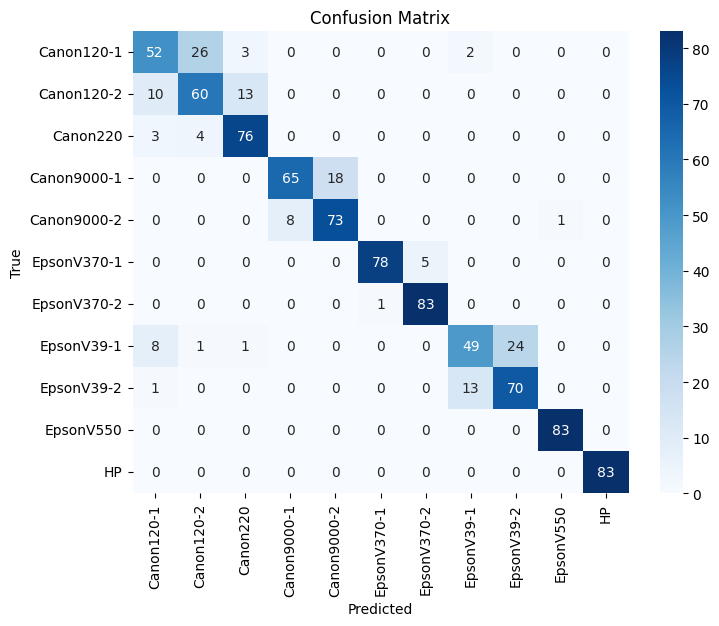

In [15]:
# Hybrid CNN (Residual Image + Handcrafted Features) with GPU


# ---- Imports & Paths ----
import os, pickle, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern as sk_lbp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RES_PATH  = "Residuals_Paths/official_wiki_residuals.pkl"
FP_PATH   = "scanner_fingerprints.pkl"
ORDER_NPY = "fp_keys.npy"
ART_DIR   = "Residuals_Paths"
os.makedirs(ART_DIR, exist_ok=True)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- GPU Setup ----
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/GPU:0'
    print(" Using GPU:", gpus[0])
else:
    device_name = '/CPU:0'
    print(" GPU not found, using CPU")

# ---- Load residuals + fingerprints ----
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()


def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# ---- Build dataset ----
X_img, X_feat, y = [], [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                X_img.append(np.expand_dims(res, axis=-1))
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                v_fft  = fft_radial_energy(res, K=6)
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
                X_feat.append(v_corr + v_fft + v_lbp)
                y.append(scanner)

X_img  = np.array(X_img, dtype=np.float32)
X_feat = np.array(X_feat, dtype=np.float32)
y       = np.array(y)

# ---- Encode labels ----
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y_cat, test_size=0.2, random_state=SEED, stratify=y_int
)

scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Hybrid train:", X_img_tr.shape, X_feat_tr.shape, y_tr.shape)
print("Hybrid test :", X_img_te.shape, X_feat_te.shape, y_te.shape)


# Build, Train & Evaluate with GPU

with tf.device(device_name):
    # ---- Model ----
    img_in  = keras.Input(shape=(256,256,1), name="residual")
    feat_in = keras.Input(shape=(27,),      name="handcrafted")
    hp_kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))
    hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

    # CNN branch
    x = layers.Conv2D(32,(3,3),padding="same")(hp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(256,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Feature branch
    f = layers.Dense(64)(feat_in)
    f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
    f = layers.Dropout(0.20)(f)

    # Fusion
    z = layers.Concatenate()([x,f])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.Dropout(0.40)(z)
    out = layers.Dense(num_classes, activation="softmax")(z)

    model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid")
    model.get_layer("hp_filter").set_weights([hp_kernel])

    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    # ---- tf.data pipelines ----
    BATCH = 32
    train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
        .shuffle(len(y_tr), reshuffle_each_iteration=True)\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)

    # ---- Callbacks ----
    ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
    ]

    # ---- Train ----
    EPOCHS = 50
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

    # ---- Save model & history ----
    model.save(os.path.join(ART_DIR, "scanner_hybrid_final.keras"))
    with open(os.path.join(ART_DIR, "hybrid_training_history.pkl"), "wb") as f:
        pickle.dump(history.history, f)
    print(" Training complete")

    # ---- Evaluate ----
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_te, axis=1)


    test_acc = accuracy_score(y_true, y_pred)
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [16]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)


GPUs detected: []


### Testing                                                                 

In [20]:
import os
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2


# Paths

ART_DIR = "Residuals_Paths"
FP_PATH = "scanner_fingerprints.pkl"
ORDER_NPY = "fp_keys.npy"
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")


# Reload for inference
hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)


# Utility functions

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()


# Preprocess + Features

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v


# Prediction function

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))
    x_ft  = make_feats_from_res(res)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf


# Multiple image prediction

test_paths = [
   "dataset/official/Canon120-2/150/s2_41.tif",
   "dataset/official/HP/150/s11_7.tif",
   "dataset/Wikipedia/Canon120-1/300/s1_9.tif",
]

for p in test_paths:
    label, conf = predict_scanner_hybrid(p)
    print(f"{p} -> {label} | Confidence: {conf:.2f}%")


dataset/official/Canon120-2/150/s2_41.tif -> Canon120-2 | Confidence: 75.02%
dataset/official/HP/150/s11_7.tif -> HP | Confidence: 99.97%
dataset/Wikipedia/Canon120-1/300/s1_9.tif -> Canon120-1 | Confidence: 82.46%


In [23]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2


# Paths

ART_DIR = "Residuals_Paths"
FP_PATH = "scanner_fingerprints.pkl"
ORDER_NPY = "fp_keys.npy"
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")


# Reload for inference

hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)


# Utility functions

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()


# Preprocess + Features

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v


# Prediction function

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))  # (1,256,256,1)
    x_ft  = make_feats_from_res(res)          # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf


# Predict all images in a folder

def predict_folder(folder_path, exts=("*.tif","*.png","*.jpg","*.jpeg")):
    # Gather all files recursively
    image_files = []
    for ext in exts:
        image_files.extend(glob.glob(os.path.join(folder_path, "**", ext), recursive=True))
    print(f"Found {len(image_files)} images in {folder_path}")

    # Predict each
    results = []
    for img_path in image_files:
        try:
            label, conf = predict_scanner_hybrid(img_path)
            results.append((img_path, label, conf))
            print(f"{img_path} -> {label} | Confidence: {conf:.2f}%")
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")
    return results


# Example usage

folder_to_test = "Test"
all_results = predict_folder(folder_to_test)


Found 3 images in Test
Test\s10_28.tif -> EpsonV550 | Confidence: 100.00%
Test\s11_4.tif -> HP | Confidence: 99.81%
Test\s2_2.tif -> Canon120-2 | Confidence: 67.73%


### Tampered detection

In [2]:
import os
ROOT = "dataset/Tampered"

# Originals PDFs to convert → TIFF
ORIG_PDF_OFF = f"{ROOT}/Originals/official"
ORIG_PDF_WIK = f"{ROOT}/Originals/wikipedia"
CONV_OUT     = f"{ROOT}/Originals_tif"           # output for converted TIFFs
os.makedirs(CONV_OUT, exist_ok=True)

# Tampered images TIFFs
TAMP_ROOT     = f"{ROOT}/TamperedImages"
TAMP_ORIG_TIF = f"{TAMP_ROOT}/Original"                          # clean (0)
TAMP_COPY_TIF = f"{TAMP_ROOT}/Tampered/Copy-move"                # tampered (1)
TAMP_RETO_TIF = f"{TAMP_ROOT}/Tampered/Retouching"               # tampered (1)
TAMP_SPLI_TIF = f"{TAMP_ROOT}/Tampered/Splicing"                 # tampered (1)

# Artifacts / manifests
ART_DIR      = f"{ROOT}/artifacts_tamper"
MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest.csv"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)
